In [27]:
import psutil
import time

import numpy as np
import scipy
import matplotlib.pyplot as plt

In [5]:
import tenpy
import tenpy.linalg.np_conserved as npc
from tenpy.algorithms import dmrg
from tenpy.algorithms.exact_diag import ExactDiag
from tenpy.networks.mps import MPS

In [3]:
from tenpy.networks.site import SpinSite, SpinHalfSite
from tenpy.models.lattice import Chain
from tenpy.models.model import CouplingModel, NearestNeighborModel, MPOModel

In [4]:
class ClusterIsing(CouplingModel):
    def __init__(self, model_params):
        # Read out/set default parameters
        name = "Cluster Ising model"
        L = model_params.get('L', 5)
        B = model_params.get('B', 0)
        bc_MPS = model_params.get('bc_MPS', 'finite')
        
        # sites
        site = SpinHalfSite(conserve=None)

        # lattice
        bc = 'open'
        lat = Chain(L, site, bc=bc, bc_MPS=bc_MPS)

        # initialize CouplingModel
        CouplingModel.__init__(self, lat)

        # add terms of the Hamiltonian
        self.add_onsite(-B, 0, 'Sigmax')
        self.add_multi_coupling(
            -1,
            [
                ('Sigmaz', -1, 0),
                ('Sigmax', 0, 0),
                ('Sigmaz', 1, 0),
            ]
        )

        # initialize H_MPO
        MPOModel.__init__(self, lat, self.calc_H_MPO())

In [6]:
L=10
B=0.2

In [7]:
model = ClusterIsing({'B': B, 'L':L})

In [8]:
psi = MPS.from_desired_bond_dimension(model.lat.mps_sites(), 1, bc=model.lat.bc_MPS)

In [9]:
ED = ExactDiag(model, max_size=2.e6)

In [10]:
ED.build_full_H_from_mpo()

In [11]:
ED.full_diagonalization()  # the expensive part for large L

In [12]:
E0_ED, psi_ED = ED.groundstate()  # return the ground state

In [18]:
def f():
    return sum(range(100))

In [20]:
p = psutil.Process()

In [25]:
b = p.memory_info().rss

In [26]:
b/2**(30)

0.2990684509277344

In [ ]:
2**(4+30)/

So about 30 sites? But slow...

# Time with respect to number of sites

In [34]:
MAX_SIZE = 2**30

In [28]:
def ed(num_sites, B=0.0):
    start = time.time()
    model = ClusterIsing({'B': B, 'L':num_sites})

    psi = MPS.from_desired_bond_dimension(
        model.lat.mps_sites(),
        1,
        bc=model.lat.bc_MPS
    )

    ED = ExactDiag(model, max_size=MAX_SIZE)

    ED.build_full_H_from_mpo()
    ED.full_diagonalization()
    E0_ED, psi_ED = ED.groundstate()

    end = time.time()

    delta = end - start

    return delta

In [35]:
num_sites = list(range(6, 20, 2))

In [36]:
times = list()

In [37]:
for i in num_sites:
    print(f'{i} sites')

    duration = ed(i)

    print(duration/60)

    times.append(duration)

6 sites
0.0004177530606587728
8 sites
0.0006280024846394857
10 sites
0.005770043532053629
12 sites
0.22680621941884357
14 sites
8.875138505299885
16 sites


/home/kieranc/Desktop/numerical_spt_classification/code/num_spt_venv/lib/python3.12/site-packages/tenpy/algorithms/exact_diag.py:153: UserWarning: size 4.29e+09 exceeds max_size 1.07e+09
  if self._exceeds_max_size():


ValueError: You need to call one of `build_full_H_*` first!

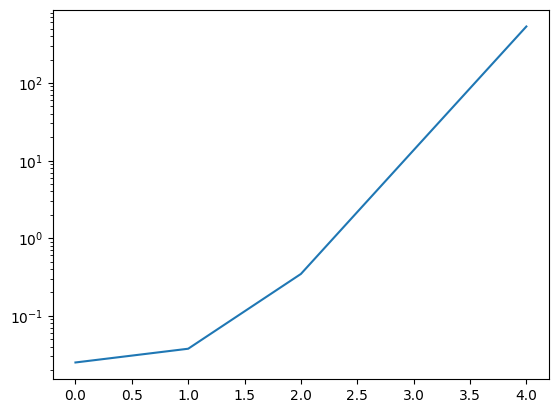

In [39]:
plt.plot(times)
plt.yscale('log')

In [40]:
times[-1]/times[-2]

39.13093092438592

So looks like 14 sites is the sweet spot.